<h1><center> Netflix Recommendation System </center></h1>

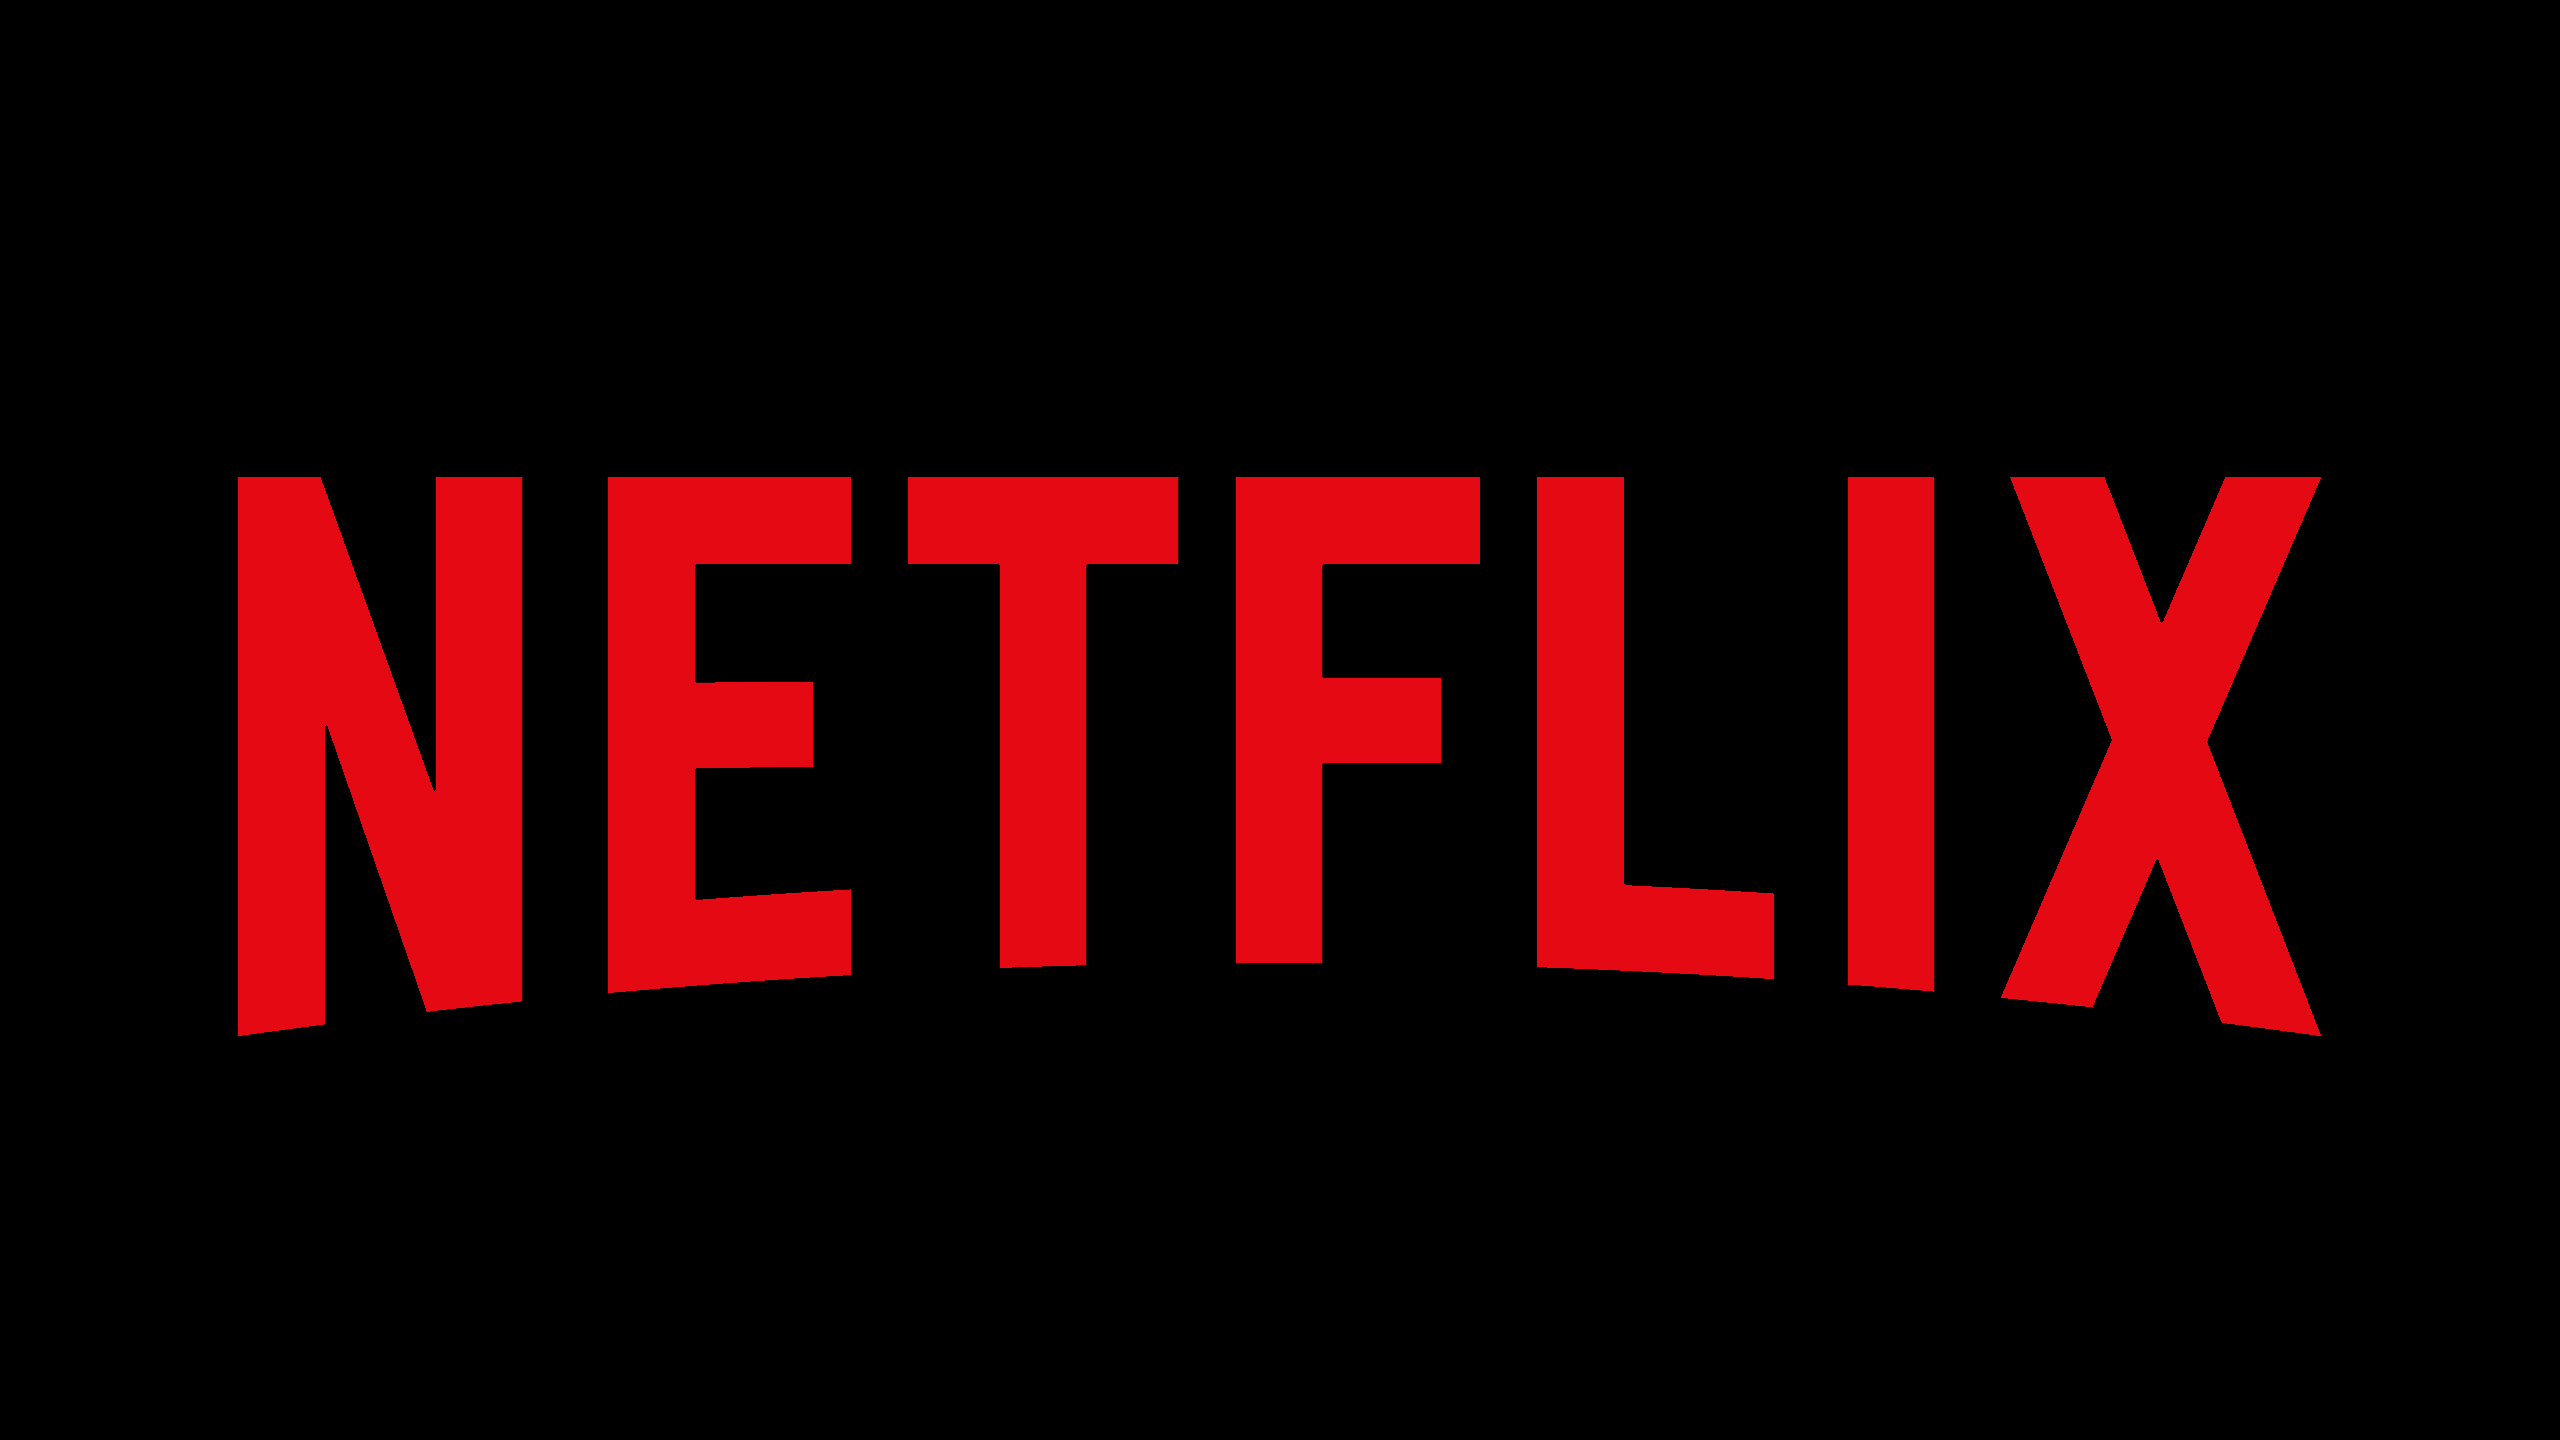

Netflix is an American over-the-top content platform and production company. Netflix was founded in 1997 and ever since has been bringing to us amazing content be it movies or series. Netflix has proven to be a total stress buster to many of us, especially considering the current pandemic around the world. They provide a vast range of content in various languages, genres, and time. May it be classics or modern pictures think about it and you may find it on Netflix.

This notebook aims at creating a movie assistant such that you can find several suggestions of must-watch based on the movies of your choice. For this, we will use the concept called "Recommender systems".

**Recommender systems** are an important class of machine learning that offer suggestions to users based on a degree of relevance. It can be categorized as collaborative filtering or a content-based system. We will create both these models for demonstration.

Kindly provide an upvote if this notebook was useful. Also, I would greatly appreciate any feedback or suggestions for improvement. 

Thank-you :)


# Data Cleaning and Processing

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import datetime
import unidecode
import numpy as np
import pandas as pd
from numpy import dot
import seaborn as sns
from numpy import random
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors   

In [ ]:
Netflix = pd.read_csv("/kaggle/input/netflix-shows/netflix_titles.csv")
print("Dataframe Details")
print("Total Rows: {}\nTotal Columns: {}".format(Netflix.shape[0],Netflix.shape[1]))

Netflix.dropna(subset=['director','cast','country','date_added','rating'],axis=0,inplace=True)
Netflix.drop(['show_id','description'],axis=1,inplace=True)
print()
print("Details after dropping null rows and columns")
print("Total Rows: {}\nTotal Columns: {}".format(Netflix.shape[0],Netflix.shape[1]))

NetflixDatabase = Netflix.copy()

print()
print("Database Created")

In [ ]:
Netflix['cast'] = Netflix['cast'].apply(lambda x : unidecode.unidecode(x))

Netflix['date_added'] = Netflix['date_added'].apply(lambda x : x[-4:])
Netflix['date_added'] = Netflix['date_added'].astype('int64')
Netflix['show_age'] = 2021 - Netflix['date_added']
Netflix['show_age'] = Netflix['show_age'].apply(lambda x : str(x)+" years")

NetflixVis = Netflix.copy()

Netflix.drop(['date_added','release_year'],axis=1,inplace=True)

print("Data Procesing Done")

# Data Visualization

In [ ]:
NetflixVis.head()

In [ ]:
sns.countplot(x = 'type', data = NetflixVis)

plt.xlabel("Show Type")
plt.ylabel("Count Of Content")

A majority of the added content on netflix seem to be movies

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
movies_rating = NetflixVis[NetflixVis['type'] == "Movie"]
movies_rating.rating.hist(bins=10)
plt.xlabel("Rating")
plt.title("Movie ratings frequency")
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
show_rating = NetflixVis[NetflixVis['type'] == "TV Show"]
show_rating.rating.hist(bins=10)
plt.xlabel("Rating")
plt.title("TV Show ratings frequency")
plt.xticks(rotation = 45)

plt.tight_layout(pad=0.4)

Netflix targets older/mature audience as there are several contents whether movies or tv shows rated as "TV Mature Audience (TV-MA)"

In [ ]:
sns.boxplot(x = 'type',y = 'date_added',data=NetflixVis)

plt.ylabel("Date Added")
plt.xlabel("Show Type")

A few movies have been added between 2008 - 2015. Many movies and TV Shows were added after 2015 and 2013 respectively.

In [ ]:
age = NetflixVis['show_age'].value_counts()[:10]
age.plot(kind='bar',title='Number of movies over the years')

Major content on Netflix is about 2 years old. Thus, pointing at several add ons in the year 2018-2019. 

In [ ]:
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
movies_duration = NetflixVis[NetflixVis['type'] == "Movie"]
movies_duration = movies_duration['duration'].value_counts()[:10]
movies_duration.plot(kind='bar',title='Number of movies over the years')
plt.xlabel("Duration")
plt.title("Top 10 Movie duration")
plt.xticks(rotation = 45)

plt.subplot(1,2,2)
show_duration = NetflixVis[NetflixVis['type'] == "TV Show"]
show_duration = show_duration['duration'].value_counts()[:10]
show_duration.plot(kind='bar',title='Number of movies over the years')
plt.xlabel("Seasons")
plt.title("Top 10 TV Shows seasons")
plt.xticks(rotation = 45)

plt.tight_layout(pad=0.3)

The length of each movie is mostly above 1 and a half hour, whereas several TV Shows seems to be limited series of 1 season.  

In [ ]:
country = NetflixVis['country'].value_counts()[:10]
country.plot(kind='bar',title='Number of movies over the years')

The United States of America is the leading content contributor followed by India.

In [ ]:
plt.figure(figsize=(20,5))

for i in range(len(country.index)):
    plt.subplot(2,5,i+1)
    moviesvsshows = NetflixVis[NetflixVis['country'] == country.index[i]]
    moviesvsshows = moviesvsshows['type'].value_counts()
    moviesvsshows.plot(kind='bar')
    plt.title("Movies vs Shows in {}".format(country.index[i]))
    plt.xticks(rotation = 360)
    
plt.tight_layout(pad=0.5)

Diving deeper into contributions we see that Egypt, The Philippines, and Indonesia are majorly contributing several movies. Although The United States of America and India are the biggest content contributor, we observe United Kingdom, Spain, Japan, Turkey, and Canada offer more TV Shows. 

In [ ]:
added_year = pd.pivot_table(NetflixVis, values='title', index='date_added', aggfunc=np.count_nonzero)
release_year = pd.pivot_table(NetflixVis, values='title', index='release_year', aggfunc=np.count_nonzero)

plt.figure(figsize=(8,4))
sns.lineplot(x='date_added', y='title', data=added_year, label='Year Added')
sns.lineplot(x='release_year', y='title', data=release_year, label='Year Release')
plt.xlabel("Year")
plt.ylabel("Number of Content")

plt.legend(shadow=True)

Movies as old as 50 years have found their way into OTT platforms

In [ ]:
genre = NetflixVis["listed_in"].value_counts()[:10]
genre.plot(kind='barh',title='Genre of movies over the years')

Netflix offer a number of Stand-ups, Dramas and International Movies  

In [ ]:
countrygenre = pd.pivot_table(NetflixVis, values='title', index=['country','listed_in'],aggfunc=np.count_nonzero).sort_values(by=['title']
                                                                                                    ,ascending=False)
countrygenre = added_year[:5]   
countrygenre.plot(kind='barh',title='Country wise genre over the years')

plt.ylabel("Countries and Genre")

The United States of America has maximum content catering to Stand-Up Comedy whereas India has a maximum genre of Drama.

# Summary of Analysis

<h4><u>Analysis based on given data</u></h4>

* Netflix offers a variety of movies ranging from different languages to a vast genre.
* In many countries OTT platforms don’t come under government censorship, thus Netflix one of such OTT platforms offers majority content catering to their "The Mature Audience".
* Initially, TV Shows had not seen the majestic light of the OTT Platform, it was first available for online streaming in the year 2013.
* Netflix offered few movies between the years 2008 - 2015, before adding a vast range thereafter.
* Several TV Shows had been added between 2017 - 2019, probably to cater to the increasing demand and fascination revolving around TV Shows.
* In the last 2 years, there were several contents added.
* Among the leading 10 countries that contributed content to Netflix The United States of America and India topped the list.
* United Kingdom, Spain, Japan, Turkey, and Canada offer more TV Shows than any other leading contributors.
* Movies and TV Shows have a maximum length of 1 and a half hours and 1 season respectively.
* Netflix has added several fine evergreen classics.
* The majority of content on Netflix is Stand-Ups, Dramas, and International Movies
* The United States of America and India have contributed several contents of Stand-ups and Drama's respectively.


# Recommendation System

## 1. Content Based Recommendation System

In [ ]:
Begin = datetime.datetime.now()

single = ['type','rating', 'show_age','duration']
lists = ['country','cast','director', 'listed_in']

for j in lists:
    Netflix[j] = Netflix[j].apply(lambda x : x.replace(" ","").split(","))

NetflixEncoded = pd.DataFrame({'Index':Netflix.index})
NetflixEncoded = NetflixEncoded.set_index('Index')
print("Encoder Dataframe Created")

In [ ]:
# CODED FOR SINGLE ENTRIES

for i in single:
    for j in Netflix[i].unique():
        NetflixEncoded[j] = 0
           
for i in range(len(Netflix)):
    row = Netflix.index[i] 
    for j in single:    
        value = Netflix[j][row]        
        NetflixEncoded.loc[row,value] = 1     

In [ ]:
# CODED FOR MULTIPLE ENTRIES
    
for i in lists:
    holder = []
    
    for j in range(len(Netflix[i])):
        row = Netflix.index[j] 
        holder.append([x.strip() for x in Netflix[i][row]])

    finalcol = [l for m in holder for l in m]
    finalcol = list(set(finalcol))
    
    for cols in finalcol:
        NetflixEncoded[cols] = 0
     
for i in range(len(Netflix)):
    row = Netflix.index[i] 
    for j in lists:
        for value in Netflix[j][row]: 
            NetflixEncoded.loc[row,value] = 1  
             
NetflixEncoded.fillna(0,inplace=True)  
print("Encoding Dataframe Done")  

In [ ]:
NetflixDatabase.reset_index(inplace=True) 
NetflixDatabase.drop('index',axis=1,inplace=True)

NetflixEncoded.reset_index(inplace=True) 
NetflixEncoded.drop('Index',axis=1,inplace=True)

print("Index Reset for 'NetflixDatabase' and 'NetflixEncoded'")  

In [ ]:
def content_recommendation_system(title):
    cossim_values = []
    
    try:
        row = NetflixDatabase[NetflixDatabase['title'] == title].index[0]
        row = NetflixEncoded.index[row]

        A = np.array(NetflixEncoded.iloc[row])

        for j in range(len(NetflixEncoded)):
            B = np.array(NetflixEncoded.iloc[j])
            cossim = dot(A,B)/(norm(A)*norm(B))
            cossim_values.append(cossim)

        NetflixDatabase['cosine_similarity'] = cossim_values
        results = NetflixDatabase.sort_values('cosine_similarity', ascending=False) 
        results = results.head(6).iloc[1:,:-1]
        return(results)
    
    except:
        print("Sorry there seems to be a problem. Kindly try another movies or show")       

In [ ]:
content_recommendation_system("Mercy")   

In [ ]:
content_recommendation_system("Gotham")   

In [ ]:
content_recommendation_system("Age")

In [ ]:
End = datetime.datetime.now()
RunTime = round((End - Begin).total_seconds()/60.0)
print("Total Time Taken by 'Content Based Recommendation System' was {} Mins".format(RunTime))  

## 2. Collaborative Based Recommendation System

Although there is no room for a collaborative recommendation system with this single dataset, let us play around with the data and explore this model.

In [ ]:
Begin = datetime.datetime.now()

userid = np.arange(1, 2000+1, 1)
userid = ["uid" + str(userid) for userid in userid]

usercols = Netflix['title'].unique()
userwatch = random.randint(5, size=(2000,len(usercols)))

watchhist = pd.DataFrame(userwatch,columns=usercols)
watchhist.insert(0,"user_id",userid)
watchhist = watchhist.set_index('user_id')
watchhist = watchhist.transpose()
watchhist.index.name = 'title'

watchhist.head()

In [ ]:
sparselist = csr_matrix(watchhist.values)
watchhist.reset_index(inplace=True)

knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)
knn.fit(sparselist)

In [ ]:
def collab_recommendation_system(title):
    
    try:
        row = watchhist[watchhist['title'] == title].index[0]

        distances , indices = knn.kneighbors(sparselist[row],n_neighbors=5+1) 
        indices = [l for m in indices.tolist() for l in m]
        distances = [l for m in distances.tolist() for l in m]

        recommendation = {}

        for i in range(1,len(indices)):
            movie_name = watchhist.iloc[indices[i]]['title']
            recommendation[movie_name] = distances[i]

        recommendation = {k: v for k, v in sorted(recommendation.items(), key=lambda item: item[1])}
        results = pd.DataFrame()

        for key,value in recommendation.items():
            row = NetflixDatabase[NetflixDatabase['title'] == key]
            results = results.append(row)

        return(results.iloc[1:,:-1])
        
    except:
        print("Sorry there seems to be a problem. Kindly try another movies or show")   

In [ ]:
collab_recommendation_system("Mercy")   

In [ ]:
collab_recommendation_system("Gotham")

In [ ]:
collab_recommendation_system("Age")

In [ ]:
End = datetime.datetime.now()
RunTime = round((End - Begin).total_seconds()/60.0)
print("Total Time Taken by 'Collaborative Based Recommendation System' was {} Mins".format(RunTime))  

# Reference

Content-Based Recommendation System:<br>
Thank you for this amazing concept. Do check out this piece<br>
https://www.kaggle.com/eward96/netflix-recommendation-engine